## Importing Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
from scipy.ndimage import gaussian_filter
import cv2

## Showing Inputs

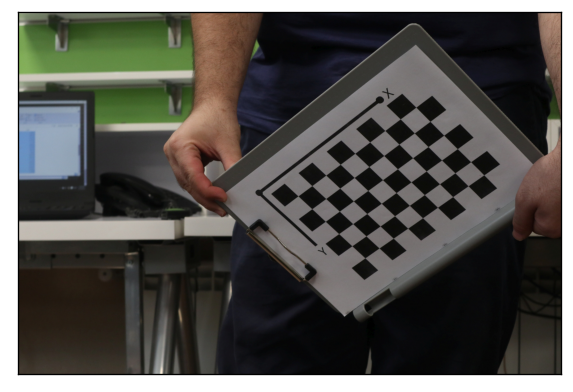

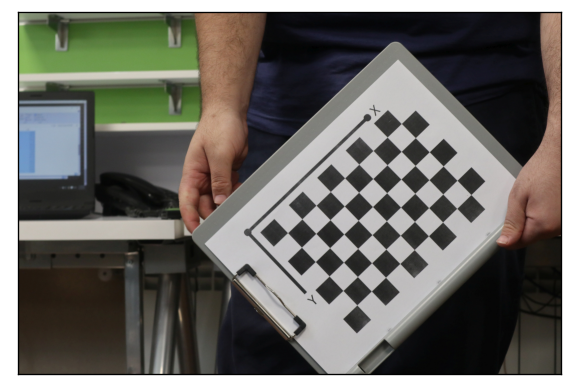

In [2]:
def show_image(img, title='', save=False, name='', ticks=True):
    '''
    a function for showing images
    '''
    plt.figure(dpi=120)
    plt.imshow(img, cmap='gray')
    if ticks:
        plt.xticks([])
        plt.yticks([])
    plt.title(title)
    if save:
        iio.imwrite(name, img)
    plt.show()
    
img1 = iio.imread('im01.jpg')
img2 = iio.imread('im02.jpg')

show_image(img1)
show_image(img2)

## Edge Detection

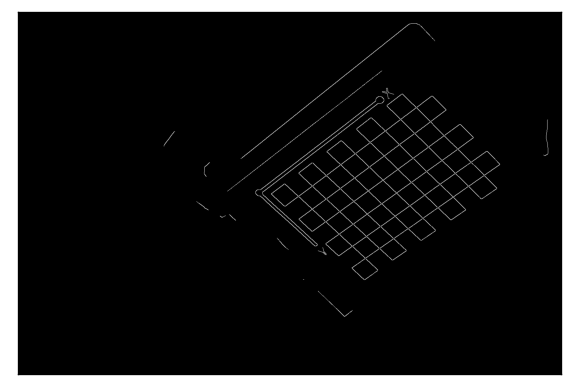

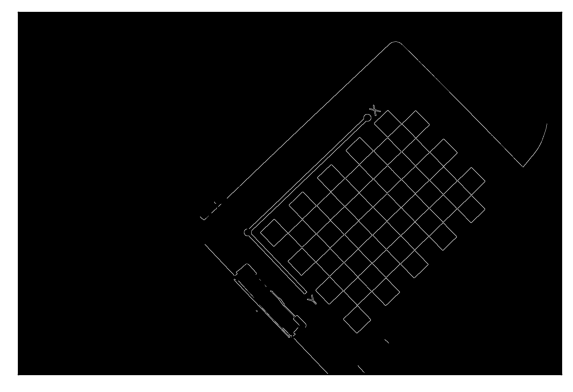

In [3]:
edge1 = cv2.Canny(img1, 400, 550)
edge2 = cv2.Canny(img2, 400, 550)
show_image(edge1, save=True, name='res01.jpg')
show_image(edge2, save=True, name='res02.jpg')

## Accumulator Matrix

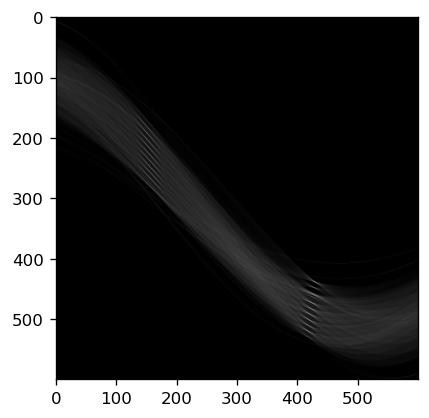

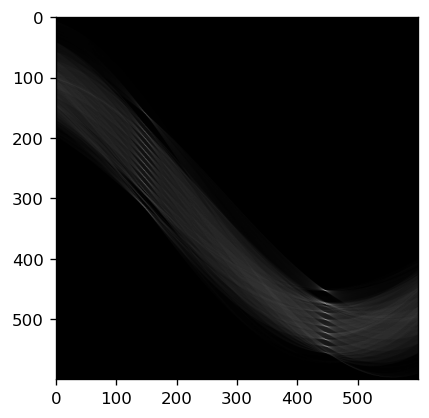

In [4]:
def acc_creater(edge, m, n, lmin, lmax):
    theta = np.linspace(-np.pi/2, np.pi/2, n)
    bins = np.linspace(lmin, lmax, m-1)
    acc = np.zeros((m, n))
    for x in range(edge.shape[0]):
        for y in range(edge.shape[1]):
            if edge[x,y] == 255:
                r = x*np.cos(theta) + y*np.sin(theta)
                r_quantize = np.digitize(r, bins)
                for k in range(len(r_quantize)):
                    acc[r_quantize[k], k] += 1
    return np.uint8((acc-np.min(acc))/(np.max(acc)-np.min(acc))*255)

n, m = 600, 600
lmin, lmax = -1500, 1500

acc1 = acc_creater(edge1, m, n, lmin, lmax)
acc2 = acc_creater(edge2, m, n, lmin, lmax)

show_image(acc1, save=True, name='res03-hough-space.jpg', ticks=False)
show_image(acc2, save=True, name='res04-hough-space.jpg', ticks=False)

## Threshold Accumulator

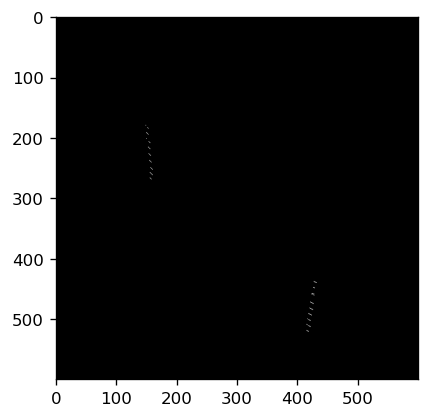

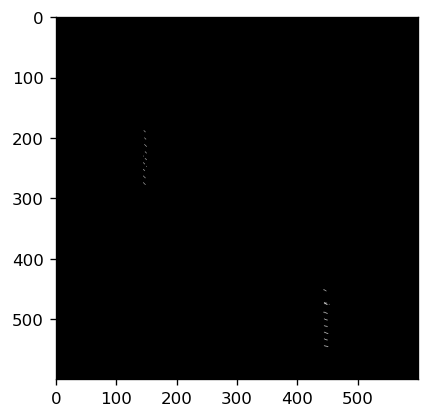

In [6]:
def thresh_acc(acc, thresh):
    out = np.zeros(acc.shape)
    for i in range(acc.shape[0]):
        for j in range(acc.shape[1]):
            if acc[i, j] >= thresh:
                out[i, j] = 255
    return out

acc1t = thresh_acc(acc1, 140)
acc2t = thresh_acc(acc2, 130)
show_image(acc1t, ticks=False)
show_image(acc2t, ticks=False)

## Drawing Lines

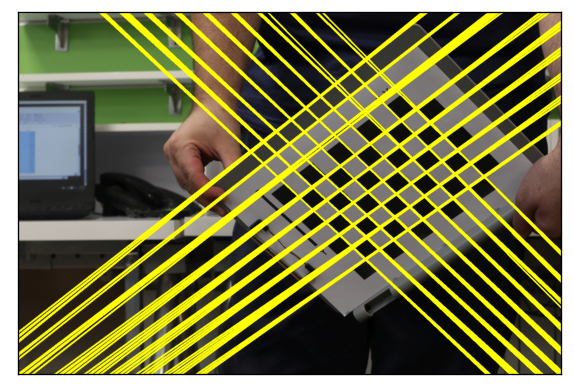

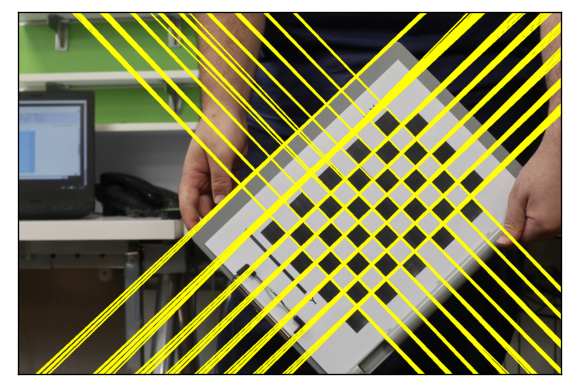

In [7]:
def draw_lines(img, acc, theta, bins, name=''):
    img = img.copy()
    for theta_num in range(acc.shape[1]):
        for r_num in range(acc.shape[0]):
            if acc[r_num, theta_num] == 255:
                theta0 = theta[theta_num]
                r0 = bins[r_num]
                (x0, y0) = (0, int(r0//np.sin(theta0)))
                if r0 > 0:
                    (x1, y1) = (int(r0//np.cos(theta0)), 0)
                else:
                    (x1, y1) = (int((r0-1500*np.sin(theta0))//np.cos(theta0)), 1500)
                cv2.line(img, (y0, x0), (y1, x1), (255, 255, 0), 3)
    show_image(img, save=True, name=name)
                

theta = np.linspace(-np.pi/2, np.pi/2, n)
bins = np.linspace(lmin, lmax, m-1)
draw_lines(img1, acc1t, theta, bins, 'res05-lines.jpg')
draw_lines(img2, acc2t, theta, bins, 'res06-lines.jpg')

## Better Thresholding

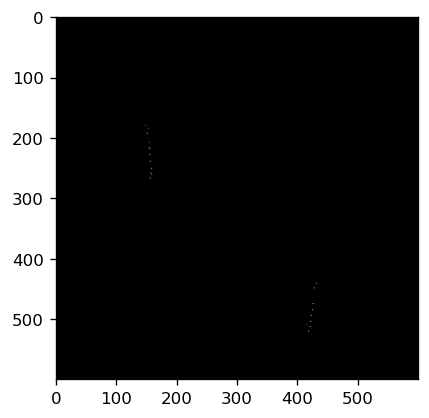

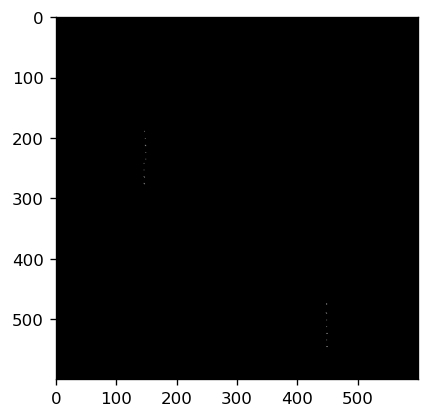

In [64]:
def filt(img):
    img = img.copy()
    for i in range(10, img.shape[0]-10):
        for j in range(10, img.shape[1]-10):
            one = 0
            if img[i+1,j] == 255:
                one += 1
            if img[i-1,j] == 255:
                one += 1
            if img[i,j+1] == 255:
                one += 1
            if img[i,j-1] == 255:
                one += 1
            if img[i+1,j+1] == 255:
                one += 1
            if img[i+1,j-1] == 255:
                one += 1
            if img[i-1,j+1] == 255:
                one += 1
            if img[i-1,j-1] == 255:
                one += 1
            if one >= 3:
                img[i+1,j] = 0
                img[i-1,j] = 0
                img[i,j+1] = 0
                img[i,j-1] = 0
                img[i+1,j+1] = 0
                img[i+1,j-1] = 0
                img[i-1,j+1] = 0
                img[i-1,j-1] = 0
    return img
def thresh_acc(acc, thresh, t1, t2):
    out = np.zeros(acc.shape)
    for i in range(acc.shape[0]):
        for j in range(acc.shape[1]):
            if acc[i, j] >= thresh:
                out[i, j] = 255
    out = gaussian_filter(out, sigma=1)
    out = filt(out)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            if out[i, j] >= t1 and i < 300:
                out[i, j] = 255
            elif out[i, j] >= t2 and i > 300:
                out[i, j] = 255
            else:
                out[i, j] = 0
    out = filt(out)
    return out

acc1t = thresh_acc(acc1, 135, 60, 50)
acc2t = thresh_acc(acc2, 130, 60, 80)
show_image(acc1t, ticks=False)
show_image(acc2t, ticks=False)

## Drawing Lines

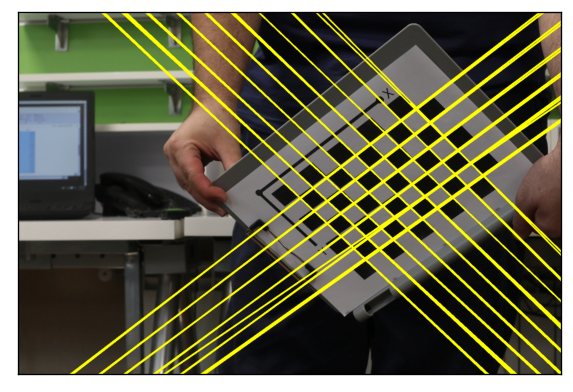

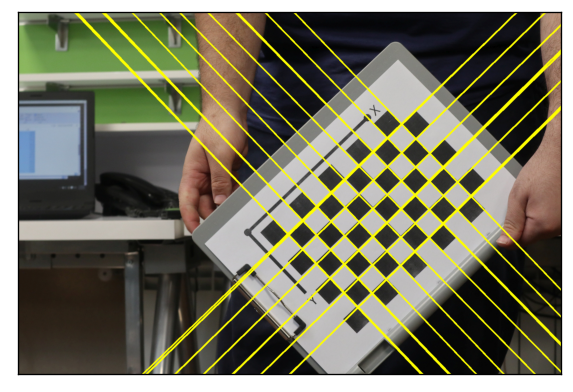

In [65]:
def draw_lines(img, acc, theta, bins, name='', min_dist=800):
    img = img.copy()
    for theta_num in range(acc.shape[1]):
        for r_num in range(acc.shape[0]):
            if acc[r_num, theta_num] == 255:
                theta0 = theta[theta_num]
                r0 = bins[r_num]
                (x0, y0) = (0, int(r0//np.sin(theta0)))
                if r0 > min_dist:
                    (x1, y1) = (int(r0//np.cos(theta0)), 0)
                else:
                    (x1, y1) = (int((r0-1500*np.sin(theta0))//np.cos(theta0)), 1500)
                cv2.line(img, (y0, x0), (y1, x1), (255, 255, 0), 3)
    show_image(img, save=True, name=name)
                

theta = np.linspace(-np.pi/2, np.pi/2, n)
bins = np.linspace(lmin, lmax, m-1)
draw_lines(img1, acc1t, theta, bins, 'res07-chess.jpg', 820)
draw_lines(img2, acc2t, theta, bins, 'res08-chess.jpg', 900)